In [3]:
# Google Colab Optimized Imports
import torch
import gc
import os
from datasets import load_dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
import psutil
import time

# Colab-specific optimizations
torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
torch.backends.cudnn.deterministic = False  # Speed over reproducibility

# Check GPU memory
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Available GPU Memory: {torch.cuda.memory_reserved(0) / 1e9:.1f} GB")
else:
    print("No GPU available - using CPU")

# Load dataset
print("\nLoading dataset...")
ds = load_dataset("ykumards/open-i")
print(f"Dataset loaded: {len(ds['train'])} samples")


GPU: Tesla T4
GPU Memory: 15.8 GB
Available GPU Memory: 0.0 GB

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset loaded: 3851 samples


In [5]:
# Colab-optimized dataset creation with memory management
def create_dataset_colab(ds, max_samples=None):
    """Create dataset with Colab memory optimizations"""
    dataset = []
    corrupted_count = 0

    # Limit samples for Colab if needed
    total_samples = len(ds['train'])
    if max_samples:
        total_samples = min(total_samples, max_samples)

    print(f"Processing {total_samples} samples...")

    for i in tqdm(range(total_samples), desc="Processing images"):
        # Clear cache every 100 images to prevent OOM
        if i % 100 == 0:
            gc.collect()
            torch.cuda.empty_cache()

        # Validate image first
        image_bytes = ds['train'][i]['img_frontal']
        try:
            # Try to open and verify the image
            img = Image.open(io.BytesIO(image_bytes))
            img.verify()
            # Reopen after verify
            img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            img.load()

            # Resize large images to save memory
            if img.size[0] > 512 or img.size[1] > 512:
                img = img.resize((512, 512), Image.Resampling.LANCZOS)

        except Exception as e:
            corrupted_count += 1
            continue

        # Create caption
        problems = ds['train'][i]['Problems'] if ds['train'][i]['Problems'] else ""
        findings = ds['train'][i]['findings'] if ds['train'][i]['findings'] else ""
        caption = f"Medical findings: {problems}. {findings}".strip()
        if not caption or caption == "Medical findings: . ":
            caption = "Normal medical image"

        dataset.append({'caption': caption, 'image_frontal': image_bytes})

    print(f"Removed {corrupted_count} corrupted images")
    return dataset

# Create clean dataset (limit to 2000 for Colab)
print("Creating and validating dataset...")
ds1 = create_dataset_colab(ds, max_samples=3000)  # Limit for Colab
print(f"Created {len(ds1)} valid image-caption pairs")
print("Sample caption:", ds1[0]['caption'])


Creating and validating dataset...
Processing 3000 samples...


Processing images: 100%|██████████| 3000/3000 [04:40<00:00, 10.70it/s]

Removed 131 corrupted images
Created 2869 valid image-caption pairs
Sample caption: Medical findings: normal. The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.


In [6]:
# Split dataset
train_list, temp_list = train_test_split(ds1, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(temp_list, test_size=0.5, random_state=42)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

Train: 2295, Val: 287, Test: 287


In [7]:
# Colab-optimized Dataset class with preprocessing
class MedicalDatasetColab(Dataset):
    def __init__(self, dataset, processor, preprocess=True):
        self.dataset = dataset
        self.processor = processor
        self.preprocess = preprocess

        # Preprocess all images once if requested
        if preprocess:
            print("Preprocessing images for faster training...")
            self.processed_data = self._preprocess_all()
        else:
            self.processed_data = None

    def _preprocess_all(self):
        """Preprocess all images once to avoid repeated processing"""
        processed = []

        for i in tqdm(range(len(self.dataset)), desc="Preprocessing"):
            item = self.dataset[i]

            # Load and process image
            image_bytes = item['image_frontal']
            image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

            # Resize if too large
            if image.size[0] > 512 or image.size[1] > 512:
                image = image.resize((512, 512), Image.Resampling.LANCZOS)

            # Process with BLIP processor
            inputs = self.processor(
                images=image,
                text=item['caption'],
                return_tensors="pt",
                padding="max_length",
                max_length=77,
                truncation=True
            )

            processed.append({
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0)
            })

            # Clear memory every 50 images
            if i % 50 == 0:
                gc.collect()

        return processed

    def __getitem__(self, index):
        if self.preprocess and self.processed_data:
            return self.processed_data[index]
        else:
            # Original processing (slower)
            item = self.dataset[index]
            image_bytes = item['image_frontal']
            image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

            inputs = self.processor(
                images=image,
                text=item['caption'],
                return_tensors="pt",
                padding="max_length",
                max_length=77,
                truncation=True
            )

            return {
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0)
            }

    def __len__(self):
        return len(self.dataset)

# Define processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Using device: {device}")
print(f"Model loaded on {device}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda
Model loaded on cuda


In [8]:
# Create dataset objects with preprocessing
print("\nCreating dataset objects...")
train_ds = MedicalDatasetColab(train_list, processor, preprocess=True)
val_ds = MedicalDatasetColab(val_list, processor, preprocess=True)
test_ds = MedicalDatasetColab(test_list, processor, preprocess=True)

# Colab-optimized data loaders
batch_size = 16  # Increased from 8 for better GPU utilization
num_workers = 2  # Colab-optimized

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,  # Keep workers alive
    prefetch_factor=2  # Prefetch batches
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")


Creating dataset objects...
Preprocessing images for faster training...


Preprocessing: 100%|██████████| 2295/2295 [04:28<00:00,  8.56it/s]


Preprocessing images for faster training...


Preprocessing: 100%|██████████| 287/287 [00:29<00:00,  9.61it/s]


Preprocessing images for faster training...


Preprocessing: 100%|██████████| 287/287 [00:30<00:00,  9.38it/s]

Train batches: 144
Val batches: 18
Test batches: 18
Batch size: 16


In [9]:
# Colab-optimized training functions with mixed precision
def train_epoch_colab(model, dataloader, optimizer, device, scaler, max_grad_norm=1.0):
    """Training epoch with Colab optimizations"""
    model.train()
    total_loss = 0

    # Memory monitoring
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Training")):
        # Move to device
        pixel_values = batch['pixel_values'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )
            loss = outputs.loss

        # Mixed precision backward pass
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Clear cache every 10 batches
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()

    # Print memory usage
    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_allocated() / 1e9
        print(f"Peak GPU memory usage: {peak_memory:.2f} GB")

    return total_loss / len(dataloader)


def validate_epoch_colab(model, dataloader, device):
    """Validation epoch with Colab optimizations"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            pixel_values = batch['pixel_values'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)

            with autocast():
                outputs = model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids
                )
                total_loss += outputs.loss.item()

    return total_loss / len(dataloader)


# Setup training with Colab optimizations
print("\nSetting up training...")
num_epochs = 10
learning_rate = 5e-5
weight_decay = 0.01

# Optimizer with Colab-friendly settings
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    eps=1e-8  # Better numerical stability
)

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Mixed precision scaler
scaler = GradScaler()

# Track best model
best_val_loss = float('inf')
patience = 5
patience_counter = 0

print(f"Training setup complete:")
print(f"- Epochs: {num_epochs}")
print(f"- Learning rate: {learning_rate}")
print(f"- Batch size: {batch_size}")
print(f"- Mixed precision: Enabled")



Setting up training...
Training setup complete:
- Epochs: 10
- Learning rate: 5e-05
- Batch size: 16
- Mixed precision: Enabled


/tmp/ipython-input-3731165843.py:94: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"{'='*50}")

    # Training
    train_loss = train_epoch_colab(model, train_loader, optimizer, device, scaler)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate_epoch_colab(model, val_loader, device)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step()

    # Calculate timing
    epoch_time = time.time() - epoch_start

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.1f}s")

    # Memory cleanup
    gc.collect()
    torch.cuda.empty_cache()

    # Model checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0


    else:
        patience_counter += 1
        print(f"⚠ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

total_time = time.time() - start_time
print("\n" + "="*60)
print("Training completed!")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Average epoch time: {total_time/num_epochs:.1f}s")
print("="*60)



Epoch 1/10
Learning rate: 0.000050


Training:   0%|          | 0/144 [00:00<?, ?it/s]/tmp/ipython-input-3731165843.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 144/144 [02:15<00:00,  1.07it/s]


Peak GPU memory usage: 13.57 GB


Validation:   0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipython-input-3731165843.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 18/18 [00:05<00:00,  3.19it/s]


Train Loss: 2.7542
Val Loss: 1.0782
Epoch Time: 140.8s

Epoch 2/10
Learning rate: 0.000049


Training: 100%|██████████| 144/144 [02:17<00:00,  1.05it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.33it/s]


Train Loss: 0.8346
Val Loss: 0.8270
Epoch Time: 142.6s

Epoch 3/10
Learning rate: 0.000045


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


Train Loss: 0.6263
Val Loss: 0.7324
Epoch Time: 144.3s

Epoch 4/10
Learning rate: 0.000040


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.26it/s]


Train Loss: 0.5135
Val Loss: 0.7068
Epoch Time: 144.2s

Epoch 5/10
Learning rate: 0.000033


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.32it/s]


Train Loss: 0.4213
Val Loss: 0.6860
Epoch Time: 144.1s

Epoch 6/10
Learning rate: 0.000025


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s]


Train Loss: 0.3449
Val Loss: 0.6957
Epoch Time: 144.0s
⚠ No improvement. Patience: 1/5

Epoch 7/10
Learning rate: 0.000017


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.29it/s]


Train Loss: 0.2837
Val Loss: 0.7028
Epoch Time: 144.2s
⚠ No improvement. Patience: 2/5

Epoch 8/10
Learning rate: 0.000010


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.29it/s]


Train Loss: 0.2376
Val Loss: 0.7144
Epoch Time: 144.1s
⚠ No improvement. Patience: 3/5

Epoch 9/10
Learning rate: 0.000005


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s]


Train Loss: 0.2059
Val Loss: 0.7227
Epoch Time: 144.1s
⚠ No improvement. Patience: 4/5

Epoch 10/10
Learning rate: 0.000001


Training: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


Peak GPU memory usage: 13.57 GB


Validation: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s]


Train Loss: 0.1890
Val Loss: 0.7256
Epoch Time: 144.3s
⚠ No improvement. Patience: 5/5
Early stopping triggered!

Training completed!
Total time: 24.0 minutes
Best validation loss: 0.6860
Average epoch time: 144.2s


In [11]:
print("\nSaving trained model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'train_loss': train_loss,
    'val_loss': val_loss,
    'best_val_loss': best_val_loss
}, '/content/blip_trained_model.pth')
print("✓ Model saved to /content/blip_trained_model.pth")

# Test the model
def test_model_colab(model, processor, test_loader, device, num_samples=3):
    """Test model with Colab optimizations"""
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples:
                break

            pixel_values = batch['pixel_values'].to(device)

            # Generate captions with optimized settings
            generated_ids = model.generate(
                pixel_values=pixel_values,
                max_length=50,
                num_beams=4,
                early_stopping=True,
                do_sample=False  # Deterministic for faster generation
            )

            # Decode the generated captions
            generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

            print(f"\nSample {i+1}:")
            print(f"Generated: {generated_captions[0]}")
            print("-" * 50)

# Test the model
print("Testing the trained model...")
test_model_colab(model, processor, test_loader, device, num_samples=3)



Saving trained model...
✓ Model saved to /content/blip_trained_model.pth
Testing the trained model...

Sample 1:
Generated: medical findings : normal. the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
--------------------------------------------------

Sample 2:
Generated: medical findings : normal. the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. cardio mediastinal silhouette is unremarkable. visual
--------------------------------------------------

Sample 3:
Generated: medical findings : cardiomegaly ; aorta ; opacity ; pulmonary atelectasis ; cicatrix ; cicatrix ;
--------------------------------------------------


In [12]:
# Add the missing predict_from_image_colab function
def predict_from_image_colab(image_input, model, processor, device):
    """Optimized inference for Colab"""
    model.eval()

    # Handle different image input types
    if isinstance(image_input, str):  # File path
        image = Image.open(image_input).convert("RGB")
    elif isinstance(image_input, bytes):  # Bytes
        image = Image.open(io.BytesIO(image_input)).convert("RGB")
    elif isinstance(image_input, Image.Image):  # PIL Image
        image = image_input.convert("RGB")
    else:
        raise ValueError("Image must be a file path, bytes, or PIL Image")

    # Resize if too large (Colab memory optimization)
    if image.size[0] > 512 or image.size[1] > 512:
        image = image.resize((512, 512), Image.Resampling.LANCZOS)

    # Process and generate
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            pixel_values=pixel_values,
            max_length=50,
            num_beams=4,
            early_stopping=True
        )

    caption = processor.decode(generated_ids[0], skip_special_tokens=True)
    return caption


In [13]:
# Simple function to check model performance
def check_model_performance(model, processor, device, test_list, num_samples=5):
    """
    Simple function to compare generated vs ground truth captions
    """
    print(f"Model Performance Check ({num_samples} samples)")
    print("=" * 50)

    for i in range(min(num_samples, len(test_list))):
        sample = test_list[i]
        ground_truth = sample['caption']

        # Generate caption
        generated = predict_from_image_colab(sample['image_frontal'], model, processor, device)

        # Display results
        print(f"\nSample {i+1}:")
        print(f"Generated: {generated}")
        print(f"Ground Truth: {ground_truth}")
        print("-" * 40)

    print(f"\nCompleted check on {min(num_samples, len(test_list))} samples!")

In [14]:
check_model_performance(model, processor, device, test_list, num_samples=5)


Model Performance Check (5 samples)

Sample 1:
Generated: medical findings : normal. the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Ground Truth: Medical findings: Thoracic Vertebrae. The heart size and cardiopulmonary silhouette is normal. There is no focal airspace opacity, pleural effusion, or pneumothorax. The obstruction are intact with mild degenerative change in the thoracic spine.
----------------------------------------

Sample 2:
Generated: medical findings : normal. the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. cardio mediastinal silhouette is unremarkable. visual
Ground Truth: Medical findings: Spine. Normal cardiomediastinal silhouette. There is no focal consolidation. There are no XXXX of a large pleural effusion. There is no pneumothorax. There is no acute bony abnormality seen. Mild degenerative changes of the spine.
----------------------------------------

Samp

Starting comprehensive accuracy evaluation...
Evaluating accuracy on 20 samples...


Evaluating: 100%|██████████| 20/20 [00:20<00:00,  1.00s/it]



ACCURACY EVALUATION RESULTS
Average Semantic Similarity: 0.301
High Accuracy (≥0.7): 0/20 (0.0%)
Medium Accuracy (0.4-0.7): 7/20 (35.0%)
Low Accuracy (<0.4): 13/20 (65.0%)

DETAILED ANALYSIS

TOP 3 BEST PREDICTIONS:
----------------------------------------

1. Similarity: 0.650
   Generated: medical findings : normal. the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute bone abnormality.
   Ground Truth: Medical findings: normal. The lungs are clear without evidence of focal airspace disease. There is no evidence of pneumothorax or large pleural effusion. The cardiac and mediastinal contours are within normal limits. The XXXX are unremarkable.
   Conditions Match: 0.750

2. Similarity: 0.600
   Generated: medical findings : normal. the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. cardio mediastinal silhouette is unremarkabl

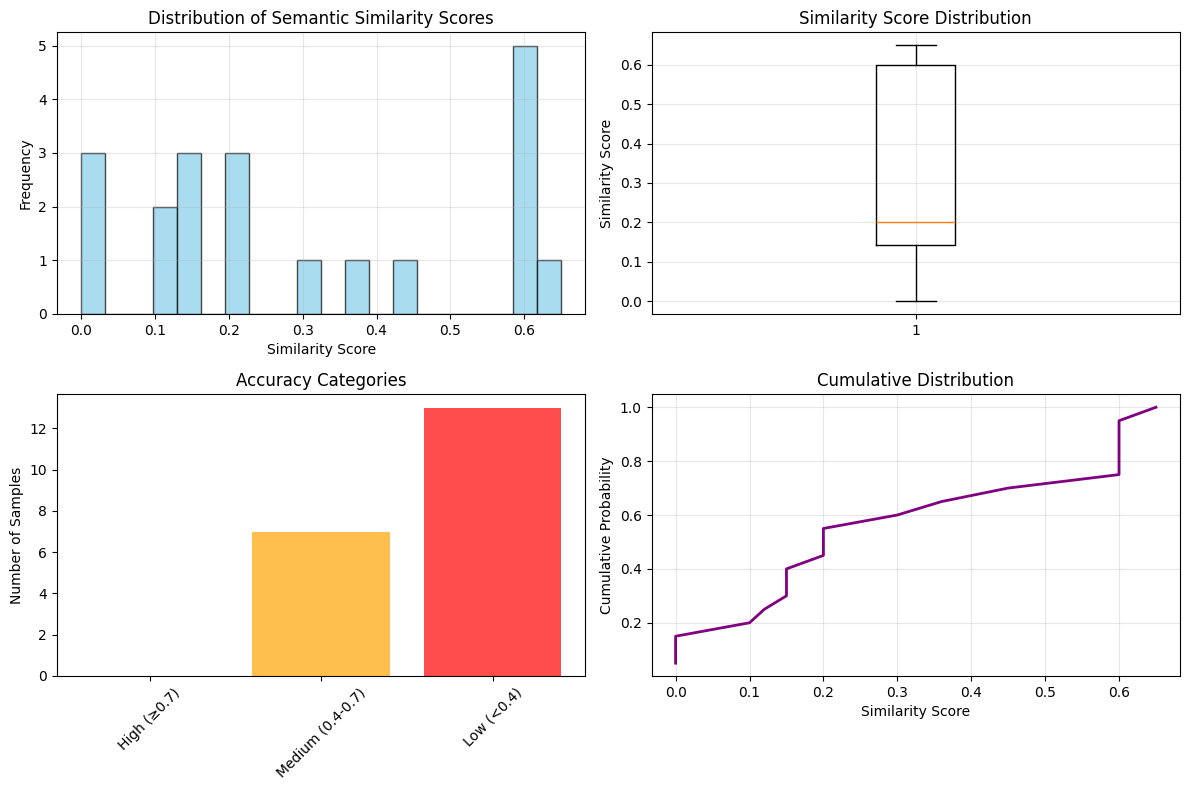


SIMILARITY STATISTICS:
Mean: 0.301
Median: 0.200
Std Dev: 0.228
Min: 0.000
Max: 0.650


In [15]:
# Medical Classification and Accuracy Evaluation Module
import re
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

class MedicalClassificationEvaluator:
    """
    Comprehensive evaluation system for medical image captioning accuracy
    """

    def __init__(self):
        # Define medical condition categories
        self.medical_conditions = {
            'normal': ['normal', 'no acute', 'no significant', 'unremarkable', 'clear'],
            'pneumonia': ['pneumonia', 'consolidation', 'infiltrate', 'opacity'],
            'cardiomegaly': ['cardiomegaly', 'enlarged heart', 'cardiac enlargement'],
            'atelectasis': ['atelectasis', 'collapse', 'compression'],
            'effusion': ['effusion', 'pleural effusion', 'fluid'],
            'pneumothorax': ['pneumothorax', 'air leak', 'collapsed lung'],
            'edema': ['edema', 'swelling', 'fluid retention'],
            'mass': ['mass', 'nodule', 'lesion', 'tumor'],
            'fracture': ['fracture', 'break', 'crack', 'displacement'],
            'foreign_body': ['foreign body', 'foreign object', 'implant']
        }

        # Severity indicators
        self.severity_indicators = {
            'mild': ['mild', 'slight', 'minimal', 'small'],
            'moderate': ['moderate', 'medium', 'intermediate'],
            'severe': ['severe', 'significant', 'extensive', 'large', 'marked']
        }

        # Location indicators
        self.location_indicators = {
            'left': ['left', 'lateral'],
            'right': ['right', 'lateral'],
            'bilateral': ['bilateral', 'both', 'bilateral'],
            'upper': ['upper', 'superior', 'apical'],
            'lower': ['lower', 'inferior', 'basal'],
            'central': ['central', 'middle']
        }

    def extract_medical_conditions(self, text):
        """Extract medical conditions from text"""
        text_lower = text.lower()
        found_conditions = []

        for condition, keywords in self.medical_conditions.items():
            for keyword in keywords:
                if keyword in text_lower:
                    found_conditions.append(condition)
                    break

        return list(set(found_conditions))  # Remove duplicates

    def extract_severity(self, text):
        """Extract severity indicators from text"""
        text_lower = text.lower()
        found_severity = []

        for severity, keywords in self.severity_indicators.items():
            for keyword in keywords:
                if keyword in text_lower:
                    found_severity.append(severity)
                    break

        return list(set(found_severity))

    def extract_locations(self, text):
        """Extract location indicators from text"""
        text_lower = text.lower()
        found_locations = []

        for location, keywords in self.location_indicators.items():
            for keyword in keywords:
                if keyword in text_lower:
                    found_locations.append(location)
                    break

        return list(set(found_locations))

    def calculate_semantic_similarity(self, generated, ground_truth):
        """Calculate semantic similarity between generated and ground truth text"""
        # Extract conditions from both texts
        gen_conditions = set(self.extract_medical_conditions(generated))
        gt_conditions = set(self.extract_medical_conditions(ground_truth))

        # Calculate Jaccard similarity for conditions
        if len(gen_conditions) == 0 and len(gt_conditions) == 0:
            condition_similarity = 1.0
        elif len(gen_conditions) == 0 or len(gt_conditions) == 0:
            condition_similarity = 0.0
        else:
            intersection = len(gen_conditions.intersection(gt_conditions))
            union = len(gen_conditions.union(gt_conditions))
            condition_similarity = intersection / union

        # Extract severity from both texts
        gen_severity = set(self.extract_severity(generated))
        gt_severity = set(self.extract_severity(ground_truth))

        severity_similarity = 0.0
        if len(gen_severity) > 0 and len(gt_severity) > 0:
            if gen_severity == gt_severity:
                severity_similarity = 1.0
            elif len(gen_severity.intersection(gt_severity)) > 0:
                severity_similarity = 0.5

        # Extract locations from both texts
        gen_locations = set(self.extract_locations(generated))
        gt_locations = set(self.extract_locations(ground_truth))

        location_similarity = 0.0
        if len(gen_locations) > 0 and len(gt_locations) > 0:
            intersection = len(gen_locations.intersection(gt_locations))
            union = len(gen_locations.union(gt_locations))
            location_similarity = intersection / union

        # Weighted average of similarities
        overall_similarity = (
            0.6 * condition_similarity +
            0.2 * severity_similarity +
            0.2 * location_similarity
        )

        return {
            'overall_similarity': overall_similarity,
            'condition_similarity': condition_similarity,
            'severity_similarity': severity_similarity,
            'location_similarity': location_similarity,
            'generated_conditions': gen_conditions,
            'ground_truth_conditions': gt_conditions
        }

    def evaluate_accuracy(self, model, processor, device, test_list, num_samples=None):
        """Comprehensive accuracy evaluation"""
        if num_samples is None:
            num_samples = len(test_list)
        else:
            num_samples = min(num_samples, len(test_list))

        results = []
        all_similarities = []

        print(f"Evaluating accuracy on {num_samples} samples...")
        print("=" * 60)

        for i in tqdm(range(num_samples), desc="Evaluating"):
            sample = test_list[i]
            ground_truth = sample['caption']

            # Generate caption
            generated = predict_from_image_colab(sample['image_frontal'], model, processor, device)

            # Calculate similarity metrics
            similarity_metrics = self.calculate_semantic_similarity(generated, ground_truth)

            # Store results
            result = {
                'sample_id': i,
                'generated': generated,
                'ground_truth': ground_truth,
                'similarity_metrics': similarity_metrics
            }
            results.append(result)
            all_similarities.append(similarity_metrics['overall_similarity'])

        # Calculate overall metrics
        avg_similarity = np.mean(all_similarities)
        high_accuracy_count = sum(1 for sim in all_similarities if sim >= 0.7)
        medium_accuracy_count = sum(1 for sim in all_similarities if 0.4 <= sim < 0.7)
        low_accuracy_count = sum(1 for sim in all_similarities if sim < 0.4)

        # Print results
        print(f"\n{'='*60}")
        print("ACCURACY EVALUATION RESULTS")
        print(f"{'='*60}")
        print(f"Average Semantic Similarity: {avg_similarity:.3f}")
        print(f"High Accuracy (≥0.7): {high_accuracy_count}/{num_samples} ({high_accuracy_count/num_samples*100:.1f}%)")
        print(f"Medium Accuracy (0.4-0.7): {medium_accuracy_count}/{num_samples} ({medium_accuracy_count/num_samples*100:.1f}%)")
        print(f"Low Accuracy (<0.4): {low_accuracy_count}/{num_samples} ({low_accuracy_count/num_samples*100:.1f}%)")

        return results, {
            'avg_similarity': avg_similarity,
            'high_accuracy': high_accuracy_count,
            'medium_accuracy': medium_accuracy_count,
            'low_accuracy': low_accuracy_count,
            'total_samples': num_samples
        }

    def detailed_analysis(self, results, top_n=5):
        """Provide detailed analysis of results"""
        print(f"\n{'='*60}")
        print("DETAILED ANALYSIS")
        print(f"{'='*60}")

        # Sort by similarity score
        sorted_results = sorted(results, key=lambda x: x['similarity_metrics']['overall_similarity'], reverse=True)

        print(f"\nTOP {top_n} BEST PREDICTIONS:")
        print("-" * 40)
        for i, result in enumerate(sorted_results[:top_n]):
            metrics = result['similarity_metrics']
            print(f"\n{i+1}. Similarity: {metrics['overall_similarity']:.3f}")
            print(f"   Generated: {result['generated']}")
            print(f"   Ground Truth: {result['ground_truth']}")
            print(f"   Conditions Match: {metrics['condition_similarity']:.3f}")

        print(f"\nTOP {top_n} WORST PREDICTIONS:")
        print("-" * 40)
        for i, result in enumerate(sorted_results[-top_n:]):
            metrics = result['similarity_metrics']
            print(f"\n{i+1}. Similarity: {metrics['overall_similarity']:.3f}")
            print(f"   Generated: {result['generated']}")
            print(f"   Ground Truth: {result['ground_truth']}")
            print(f"   Conditions Match: {metrics['condition_similarity']:.3f}")

    def plot_accuracy_distribution(self, results):
        """Plot accuracy distribution"""
        similarities = [r['similarity_metrics']['overall_similarity'] for r in results]

        plt.figure(figsize=(12, 8))

        # Histogram
        plt.subplot(2, 2, 1)
        plt.hist(similarities, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Distribution of Semantic Similarity Scores')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # Box plot
        plt.subplot(2, 2, 2)
        plt.boxplot(similarities, vert=True)
        plt.title('Similarity Score Distribution')
        plt.ylabel('Similarity Score')
        plt.grid(True, alpha=0.3)

        # Accuracy categories
        plt.subplot(2, 2, 3)
        high_acc = sum(1 for s in similarities if s >= 0.7)
        med_acc = sum(1 for s in similarities if 0.4 <= s < 0.7)
        low_acc = sum(1 for s in similarities if s < 0.4)

        categories = ['High (≥0.7)', 'Medium (0.4-0.7)', 'Low (<0.4)']
        counts = [high_acc, med_acc, low_acc]
        colors = ['green', 'orange', 'red']

        plt.bar(categories, counts, color=colors, alpha=0.7)
        plt.title('Accuracy Categories')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=45)

        # Cumulative distribution
        plt.subplot(2, 2, 4)
        sorted_sims = sorted(similarities)
        y_values = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
        plt.plot(sorted_sims, y_values, linewidth=2, color='purple')
        plt.title('Cumulative Distribution')
        plt.xlabel('Similarity Score')
        plt.ylabel('Cumulative Probability')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"\nSIMILARITY STATISTICS:")
        print(f"Mean: {np.mean(similarities):.3f}")
        print(f"Median: {np.median(similarities):.3f}")
        print(f"Std Dev: {np.std(similarities):.3f}")
        print(f"Min: {np.min(similarities):.3f}")
        print(f"Max: {np.max(similarities):.3f}")

# Initialize the evaluator
evaluator = MedicalClassificationEvaluator()

# Run comprehensive evaluation
print("Starting comprehensive accuracy evaluation...")
results, summary = evaluator.evaluate_accuracy(model, processor, device, test_list, num_samples=20)

# Show detailed analysis
evaluator.detailed_analysis(results, top_n=3)

# Plot accuracy distribution
evaluator.plot_accuracy_distribution(results)